In [1]:
import time
import numpy as np
import h5py
import matplotlib.pyplot as plt
import scipy
from PIL import Image
from scipy import ndimage
from dnn_app_utils_v3 import *

%matplotlib inline
plt.rcParams['figure.figsize'] = (4.0, 4.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

np.random.seed(1)

C:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## Dataset

In [2]:
from PIL import Image
import numpy as np
import pandas as pd
import sys
import os
import csv
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob

#mendefinisikan tipe gambar yang ingin di train serta lokasi pembelajaran -----------------------------------------------------
train_path = 'img/train/*.jpg'
addrs_train = glob.glob(train_path)

#mendefinisikan fitur dan pemberian label pada gambar banjir dan bukan banjir  ---------------------------------------------------

#list
def createFileList(myDir, format='.jpg'):
    fileList = []
    print("Scanning inside " + myDir)
    for root, dirs, files in os.walk(myDir, topdown=False):
        for name in files:
            if name.endswith(format):
                fullName = os.path.join(root, name)
                fileList.append(fullName)
    return fileList


#load data gambar informasu lokasi yang diberikan 
myTrainList = createFileList('img/train/')

train_size = 275
test_size = 92
image_width = 200
image_height = 200

train_x_orig = []
#For each files in the folder, save the grayscale values
for i, file in enumerate(myTrainList):
    train_x_orig = np.append(train_x_orig, mpimg.imread(file))
    
#train_x_orig = train_x_orig.flatten()
train_x_orig = np.reshape(train_x_orig, (train_size, image_width, image_height, 3)).astype(int)
labels = [1 if 'b' in addr_train else 0 for addr_train in addrs_train]  # 0 = Normal, 1 = Banjir
train_labels = np.asarray(labels).astype(int)
train_y = np.array([train_labels][:]) # your train set labels
        
#Define where to look up the images -----------------------------------------------------
test_path = 'img/test/*.jpg'
addrs_test = glob.glob(test_path)
    
#Define features and labels for test ----------------------------------------------------

#Load the original image
myTestList = createFileList('img/test/')

test_x_orig = []
#For each files in the folder, save the grayscale values
for file in myTestList:
    test_x_orig = np.append(test_x_orig, mpimg.imread(file))
    
test_x_orig = np.reshape(test_x_orig, (test_size, image_width, image_height, 3)).astype(int)
labels = [1 if 'b' in addr_test else 0 for addr_test in addrs_test]  # 0 = Normal, 1 = Banjir
test_labels = np.asarray(labels).astype(int)
test_y = np.array([test_labels][:]) # your train set labels
        
classes = np.array([b'No Banjir', b'Banjir'], dtype=np.dtype('|S'))

print ("Done!")

Scanning inside img/train/
Scanning inside img/test/
Done!


y = 1. It's a Banjir picture.


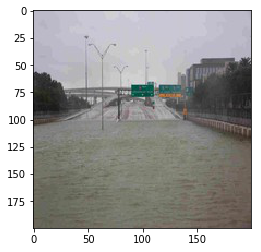

In [3]:
# contoh train
index = 1
plt.imshow(train_x_orig[index])
print ("y = " + str(train_y[0,index]) + ". It's a " + classes[train_y[0,index]].decode("utf-8") +  " picture.")

In [4]:
# Explore dataset yang ditentukan
m_train = train_x_orig.shape[0]
num_px = train_x_orig.shape[1]
m_test = test_x_orig.shape[0]

print ("Number of training examples: " + str(m_train))
print ("Number of testing examples: " + str(m_test))
print ("Each image is of size: (" + str(num_px) + ", " + str(num_px) + ", 3)")
print ("train_x_orig shape: " + str(train_x_orig.shape))
print ("train_y shape: " + str(train_y.shape))
print ("test_x_orig shape: " + str(test_x_orig.shape))
print ("test_y shape: " + str(test_y.shape))

Number of training examples: 275
Number of testing examples: 92
Each image is of size: (200, 200, 3)
train_x_orig shape: (275, 200, 200, 3)
train_y shape: (1, 275)
test_x_orig shape: (92, 200, 200, 3)
test_y shape: (1, 92)


In [5]:
train_x_flatten = train_x_orig.reshape(train_x_orig.shape[0], -1).T   # The "-1" makes reshape flatten the remaining dimensions
test_x_flatten = test_x_orig.reshape(test_x_orig.shape[0], -1).T

# Standardize data to have feature values between 0 and 1.
train_x = train_x_flatten/255.
test_x = test_x_flatten/255.

print ("train_x's shape: " + str(train_x.shape))
print ("test_x's shape: " + str(test_x.shape))


train_x's shape: (120000, 275)
test_x's shape: (120000, 92)


## Two-layer neural network

In [6]:
### CONSTANTS DEFINING THE MODEL ####
n_x = 120000    # num_px * num_px * 3
n_h = 7
n_y = 1
layers_dims = (n_x, n_h, n_y)

In [7]:
def two_layer_model(X, Y, layers_dims, learning_rate = 0.005, num_iterations = 80, print_cost=False):
    
    np.random.seed(1)
    grads = {}
    costs = []                              # to keep track of the cost
    m = X.shape[1]                           # number of examples
    (n_x, n_h, n_y) = layers_dims
    
    # Initialize parameters dictionary, by calling one of the functions you'd previously implemented
    parameters = initialize_parameters(n_x, n_h, n_y)
    
    # Get W1, b1, W2 and b2 from the dictionary parameters.
    W1 = parameters["W1"]
    b1 = parameters["b1"]
    W2 = parameters["W2"]
    b2 = parameters["b2"]
    
    # Loop (gradient descent)

    for i in range(0, num_iterations):

        # Forward propagation: LINEAR -> RELU -> LINEAR -> SIGMOID. Inputs: "X, W1, b1, W2, b2". Output: "A1, cache1, A2, cache2".
        A1, cache1 = linear_activation_forward(X, W1, b1, 'relu')
        A2, cache2 = linear_activation_forward(A1, W2, b2, 'sigmoid')
        
        # Compute cost
        cost = compute_cost(A2, Y)
        
        # Initializing backward propagation
        dA2 = - (np.divide(Y, A2) - np.divide(1 - Y, 1 - A2))
        
        # Backward propagation. Inputs: "dA2, cache2, cache1". Outputs: "dA1, dW2, db2; also dA0 (not used), dW1, db1".
        dA1, dW2, db2 = linear_activation_backward(dA2, cache2, 'sigmoid')
        dA0, dW1, db1 = linear_activation_backward(dA1, cache1, 'relu')
        
        # Set grads['dWl'] to dW1, grads['db1'] to db1, grads['dW2'] to dW2, grads['db2'] to db2
        grads['dW1'] = dW1
        grads['db1'] = db1
        grads['dW2'] = dW2
        grads['db2'] = db2
        
        # Update parameters.
        parameters = update_parameters(parameters, grads, learning_rate)

        # Retrieve W1, b1, W2, b2 from parameters
        W1 = parameters["W1"]
        b1 = parameters["b1"]
        W2 = parameters["W2"]
        b2 = parameters["b2"]
        
        # Print the cost every 100 training example
        if print_cost and i % 100 == 0:
            print("Cost after iteration {}: {}".format(i, np.squeeze(cost)))
        if print_cost and i % 100 == 0:
            costs.append(cost)
       
    # plot the cost

    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('iterations (per tens)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()
    
    return parameters

Cost after iteration 0: 0.7089896123874739
Cost after iteration 100: 0.5077338200938937
Cost after iteration 200: 0.41956294171951153
Cost after iteration 300: 0.4311579486023853
Cost after iteration 400: 0.4030774738458463
Cost after iteration 500: 0.3743001520288325
Cost after iteration 600: 0.3465761529819521
Cost after iteration 700: 0.31743316894649054
Cost after iteration 800: 0.28725262177066696
Cost after iteration 900: 0.2623408186164056
Cost after iteration 1000: 0.08827022940780516
Cost after iteration 1100: 0.06518271967222503
Cost after iteration 1200: 0.046249386288135394
Cost after iteration 1300: 0.034916739055212316
Cost after iteration 1400: 0.02735140201503329


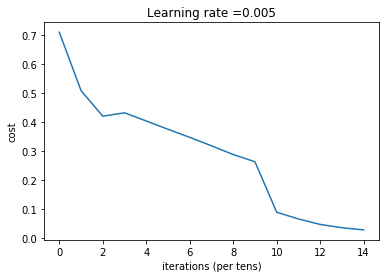

In [8]:
parameters = two_layer_model(train_x, train_y, layers_dims = (n_x, n_h, n_y), num_iterations = 1500, print_cost=True)

In [9]:
predictions_train = predict(train_x, train_y, parameters)

Accuracy: 1.0


In [10]:
predictions_test = predict(test_x, test_y, parameters)

Accuracy: 0.7934782608695653


In [11]:
def two_layer_model(X, Y, layers_dims, learning_rate = 0.01, num_iterations = 80, print_cost=False):
    
    np.random.seed(1)
    grads = {}
    costs = []                              # to keep track of the cost
    m = X.shape[1]                           # number of examples
    (n_x, n_h, n_y) = layers_dims
    
    # Initialize parameters dictionary, by calling one of the functions you'd previously implemented
    parameters = initialize_parameters(n_x, n_h, n_y)
    
    # Get W1, b1, W2 and b2 from the dictionary parameters.
    W1 = parameters["W1"]
    b1 = parameters["b1"]
    W2 = parameters["W2"]
    b2 = parameters["b2"]
    
    # Loop (gradient descent)

    for i in range(0, num_iterations):

        # Forward propagation: LINEAR -> RELU -> LINEAR -> SIGMOID. Inputs: "X, W1, b1, W2, b2". Output: "A1, cache1, A2, cache2".
        A1, cache1 = linear_activation_forward(X, W1, b1, 'relu')
        A2, cache2 = linear_activation_forward(A1, W2, b2, 'sigmoid')
        
        # Compute cost
        cost = compute_cost(A2, Y)
        
        # Initializing backward propagation
        dA2 = - (np.divide(Y, A2) - np.divide(1 - Y, 1 - A2))
        
        # Backward propagation. Inputs: "dA2, cache2, cache1". Outputs: "dA1, dW2, db2; also dA0 (not used), dW1, db1".
        dA1, dW2, db2 = linear_activation_backward(dA2, cache2, 'sigmoid')
        dA0, dW1, db1 = linear_activation_backward(dA1, cache1, 'relu')
        
        # Set grads['dWl'] to dW1, grads['db1'] to db1, grads['dW2'] to dW2, grads['db2'] to db2
        grads['dW1'] = dW1
        grads['db1'] = db1
        grads['dW2'] = dW2
        grads['db2'] = db2
        
        # Update parameters.
        parameters = update_parameters(parameters, grads, learning_rate)

        # Retrieve W1, b1, W2, b2 from parameters
        W1 = parameters["W1"]
        b1 = parameters["b1"]
        W2 = parameters["W2"]
        b2 = parameters["b2"]
        
        # Print the cost every 100 training example
        if print_cost and i % 100 == 0:
            print("Cost after iteration {}: {}".format(i, np.squeeze(cost)))
        if print_cost and i % 100 == 0:
            costs.append(cost)
       
    # plot the cost

    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('iterations (per tens)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()
    
    return parameters

Cost after iteration 0: 0.7089896123874739
Cost after iteration 100: 0.46127513163195083
Cost after iteration 200: 0.449856871368491
Cost after iteration 300: 0.41432247019271123
Cost after iteration 400: 0.38391922492460895
Cost after iteration 500: 0.3482835184270905
Cost after iteration 600: 0.30811590666367733
Cost after iteration 700: 0.12668275396212825
Cost after iteration 800: 0.16935869568613188
Cost after iteration 900: 0.19849414940739765
Cost after iteration 1000: 0.19424005458205593
Cost after iteration 1100: 0.1476487678481367
Cost after iteration 1200: 0.13521027898522425
Cost after iteration 1300: 0.12386665123090086
Cost after iteration 1400: 0.43394138228446844


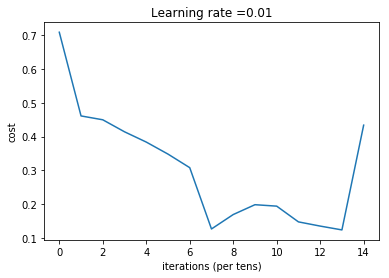

In [13]:
parameters = two_layer_model(train_x, train_y, layers_dims = (n_x, n_h, n_y), num_iterations = 1500, print_cost=True)

In [14]:
predictions_train = predict(train_x, train_y, parameters)

Accuracy: 1.0


In [15]:
predictions_test = predict(test_x, test_y, parameters)

Accuracy: 0.8043478260869567


In [18]:
def two_layer_model(X, Y, layers_dims, learning_rate = 0.005, num_iterations = 80, print_cost=False):
    
    np.random.seed(1)
    grads = {}
    costs = []                              # to keep track of the cost
    m = X.shape[1]                           # number of examples
    (n_x, n_h, n_y) = layers_dims
    
    # Initialize parameters dictionary, by calling one of the functions you'd previously implemented
    parameters = initialize_parameters(n_x, n_h, n_y)
    
    # Get W1, b1, W2 and b2 from the dictionary parameters.
    W1 = parameters["W1"]
    b1 = parameters["b1"]
    W2 = parameters["W2"]
    b2 = parameters["b2"]
    
    # Loop (gradient descent)

    for i in range(0, num_iterations):

        # Forward propagation: LINEAR -> RELU -> LINEAR -> SIGMOID. Inputs: "X, W1, b1, W2, b2". Output: "A1, cache1, A2, cache2".
        A1, cache1 = linear_activation_forward(X, W1, b1, 'relu')
        A2, cache2 = linear_activation_forward(A1, W2, b2, 'sigmoid')
        
        # Compute cost
        cost = compute_cost(A2, Y)
        
        # Initializing backward propagation
        dA2 = - (np.divide(Y, A2) - np.divide(1 - Y, 1 - A2))
        
        # Backward propagation. Inputs: "dA2, cache2, cache1". Outputs: "dA1, dW2, db2; also dA0 (not used), dW1, db1".
        dA1, dW2, db2 = linear_activation_backward(dA2, cache2, 'sigmoid')
        dA0, dW1, db1 = linear_activation_backward(dA1, cache1, 'relu')
        
        # Set grads['dWl'] to dW1, grads['db1'] to db1, grads['dW2'] to dW2, grads['db2'] to db2
        grads['dW1'] = dW1
        grads['db1'] = db1
        grads['dW2'] = dW2
        grads['db2'] = db2
        
        # Update parameters.
        parameters = update_parameters(parameters, grads, learning_rate)

        # Retrieve W1, b1, W2, b2 from parameters
        W1 = parameters["W1"]
        b1 = parameters["b1"]
        W2 = parameters["W2"]
        b2 = parameters["b2"]
        
        # Print the cost every 100 training example
        if print_cost and i % 100 == 0:
            print("Cost after iteration {}: {}".format(i, np.squeeze(cost)))
        if print_cost and i % 100 == 0:
            costs.append(cost)
       
    # plot the cost

    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('iterations (per tens)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()
    
    return parameters

Cost after iteration 0: 0.7089896123874739
Cost after iteration 100: 0.5077338200938937
Cost after iteration 200: 0.41956294171951153
Cost after iteration 300: 0.4311579486023853
Cost after iteration 400: 0.4030774738458463
Cost after iteration 500: 0.3743001520288325
Cost after iteration 600: 0.3465761529819521
Cost after iteration 700: 0.31743316894649054
Cost after iteration 800: 0.28725262177066696
Cost after iteration 900: 0.2623408186164056
Cost after iteration 1000: 0.08827022940780516
Cost after iteration 1100: 0.06518271967222503
Cost after iteration 1200: 0.046249386288135394
Cost after iteration 1300: 0.034916739055212316
Cost after iteration 1400: 0.02735140201503329
Cost after iteration 1500: 0.02204003031918241
Cost after iteration 1600: 0.01818093601401789
Cost after iteration 1700: 0.015301277716612256
Cost after iteration 1800: 0.013096865733624442
Cost after iteration 1900: 0.011376326114893741
Cost after iteration 2000: 0.010003440072559993
Cost after iteration 2100:

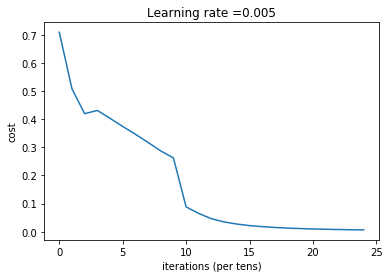

In [19]:
parameters = two_layer_model(train_x, train_y, layers_dims = (n_x, n_h, n_y), num_iterations = 2500, print_cost=True)

In [20]:
predictions_train = predict(train_x, train_y, parameters)

Accuracy: 1.0


In [21]:
predictions_test = predict(test_x, test_y, parameters)

Accuracy: 0.7934782608695653


In [22]:
def two_layer_model(X, Y, layers_dims, learning_rate = 0.01, num_iterations = 80, print_cost=False):
    
    np.random.seed(1)
    grads = {}
    costs = []                              # to keep track of the cost
    m = X.shape[1]                           # number of examples
    (n_x, n_h, n_y) = layers_dims
    
    # Initialize parameters dictionary, by calling one of the functions you'd previously implemented
    parameters = initialize_parameters(n_x, n_h, n_y)
    
    # Get W1, b1, W2 and b2 from the dictionary parameters.
    W1 = parameters["W1"]
    b1 = parameters["b1"]
    W2 = parameters["W2"]
    b2 = parameters["b2"]
    
    # Loop (gradient descent)

    for i in range(0, num_iterations):

        # Forward propagation: LINEAR -> RELU -> LINEAR -> SIGMOID. Inputs: "X, W1, b1, W2, b2". Output: "A1, cache1, A2, cache2".
        A1, cache1 = linear_activation_forward(X, W1, b1, 'relu')
        A2, cache2 = linear_activation_forward(A1, W2, b2, 'sigmoid')
        
        # Compute cost
        cost = compute_cost(A2, Y)
        
        # Initializing backward propagation
        dA2 = - (np.divide(Y, A2) - np.divide(1 - Y, 1 - A2))
        
        # Backward propagation. Inputs: "dA2, cache2, cache1". Outputs: "dA1, dW2, db2; also dA0 (not used), dW1, db1".
        dA1, dW2, db2 = linear_activation_backward(dA2, cache2, 'sigmoid')
        dA0, dW1, db1 = linear_activation_backward(dA1, cache1, 'relu')
        
        # Set grads['dWl'] to dW1, grads['db1'] to db1, grads['dW2'] to dW2, grads['db2'] to db2
        grads['dW1'] = dW1
        grads['db1'] = db1
        grads['dW2'] = dW2
        grads['db2'] = db2
        
        # Update parameters.
        parameters = update_parameters(parameters, grads, learning_rate)

        # Retrieve W1, b1, W2, b2 from parameters
        W1 = parameters["W1"]
        b1 = parameters["b1"]
        W2 = parameters["W2"]
        b2 = parameters["b2"]
        
        # Print the cost every 100 training example
        if print_cost and i % 100 == 0:
            print("Cost after iteration {}: {}".format(i, np.squeeze(cost)))
        if print_cost and i % 100 == 0:
            costs.append(cost)
       
    # plot the cost

    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('iterations (per tens)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()
    
    return parameters

Cost after iteration 0: 0.7089896123874739
Cost after iteration 100: 0.46127513163195083
Cost after iteration 200: 0.449856871368491
Cost after iteration 300: 0.41432247019271123
Cost after iteration 400: 0.38391922492460895
Cost after iteration 500: 0.3482835184270905
Cost after iteration 600: 0.30811590666367733
Cost after iteration 700: 0.12668275396212825
Cost after iteration 800: 0.16935869568613188
Cost after iteration 900: 0.19849414940739765
Cost after iteration 1000: 0.19424005458205593
Cost after iteration 1100: 0.1476487678481367
Cost after iteration 1200: 0.13521027898522425
Cost after iteration 1300: 0.12386665123090086
Cost after iteration 1400: 0.43394138228446844
Cost after iteration 1500: 0.11420203943301045
Cost after iteration 1600: 0.10407786022506936
Cost after iteration 1700: 0.09710998969088136
Cost after iteration 1800: 0.09113174893890669
Cost after iteration 1900: 0.08583444596632964
Cost after iteration 2000: 0.08123767924922376
Cost after iteration 2100: 0.0

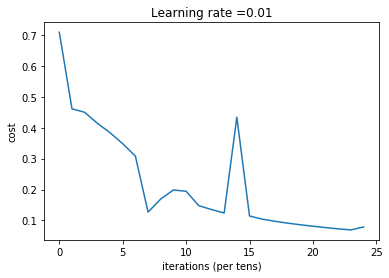

In [23]:
parameters = two_layer_model(train_x, train_y, layers_dims = (n_x, n_h, n_y), num_iterations = 2500, print_cost=True)

In [24]:
predictions_train = predict(train_x, train_y, parameters)

Accuracy: 1.0


In [25]:
predictions_test = predict(test_x, test_y, parameters)

Accuracy: 0.8152173913043479


## Test with your own image ##

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0.
Use ``matplotlib.pyplot.imread`` instead.
  """
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  


Accuracy: 0.0
y = 0.0, your L-layer model predicts a "No Banjir" picture.


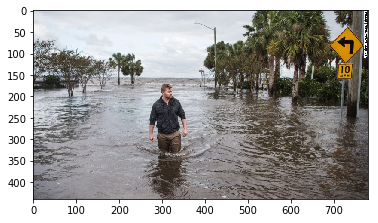

In [26]:
my_image = "test2.jpg" # change this to the name of your image file 
my_label_y = [1] # the true class of your image (1 -> cat, 0 -> non-cat)

fname = "images/" + my_image
image = np.array(ndimage.imread(fname, flatten=False))
my_image = scipy.misc.imresize(image, size=(num_px,num_px)).reshape((num_px*num_px*3,1))
my_image = my_image/255.
my_predicted_image = predict(my_image, my_label_y, parameters)

plt.imshow(image)
print ("y = " + str(np.squeeze(my_predicted_image)) + ", your L-layer model predicts a \"" + classes[int(np.squeeze(my_predicted_image)),].decode("utf-8") +  "\" picture.")